### Langevin equation 

$$
    \frac{dx}{dt} =  \frac{\partial H}{\partial \pi}  = \frac{\pi}{m}
$$

$$
  \frac{d \pi}{dt}  = -\frac{\partial H}{\partial x} - \gamma \frac{\pi}{m} + \eta(t) = -\frac{\partial S}{\partial x} - \gamma \frac{\pi}{m} + \eta(t)
$$

## Dynamics of particles in a potential and there use in MCMC

Status: Hamilton and HMC are working. Langevin is not yet working as expected too little spread / diffusion 

### Hamilton equations
$$
 \frac{dx_i}{dt} = \frac{\partial H}{\partial \pi_i}
$$

$$
 \frac{d\pi_i}{dt} = -\frac{\partial H}{\partial x_i}
$$


#### HMC Hamilton / Hybrid Monte Carlo
Use hamiltonian dynamics to propose new states for some timesteps. Then add random noise $\pi \sim N(0,M)$ to the momentum. In our version we have no Metropolis-Hastings correction, but just accept the new state. Note that the acceptance rate is 1, if the dynamics are perfect and so MH correction is not needed in principle but due to numerical errors.



<video width="600" controls>
  <source src="https://raw.githubusercontent.com/oduerr/da/master/python/phase_space_animation_HMC.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

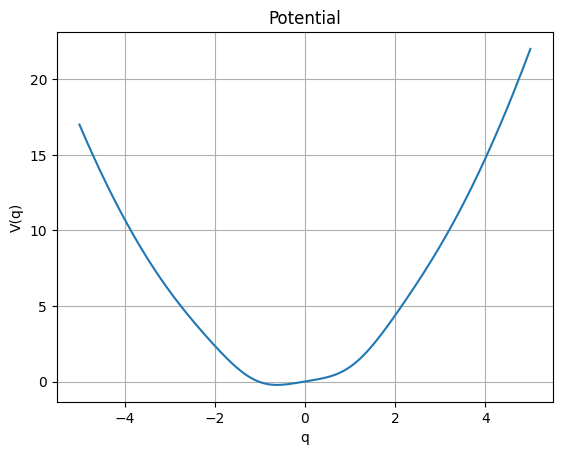

In [118]:
import jax.numpy as jnp

# Define the potential energy for the confined sinusoidal potential
def potential(q):
    k1, k2 = 1.0, 0.5  # Spring constants for the two wells
    q1, q2 = -1.0, 1.0  # Positions of the wells
    V1 = 0.5 * k1 * (q - q1)**2  # Potential energy of the first well
    V2 = 0.5 * k2 * (q - q2)**2  # Potential energy of the second well
    V = -jnp.exp(-(q - q1)**2) - jnp.exp(-(q - q2)**2) + V1 + V2  # Combined potential
    return V

# Example usage:
import matplotlib.pyplot as plt

# Generate a range of q values
q_values = jnp.linspace(-5, 5, 400)
# Calculate potential values
V_values = potential(q_values)

# Plot the potential
plt.plot(q_values, V_values)
plt.xlabel('q')
plt.ylabel('V(q)')
plt.title('Potential')
plt.grid(True)
plt.show()

### Hamilton / Langevin Mechanics

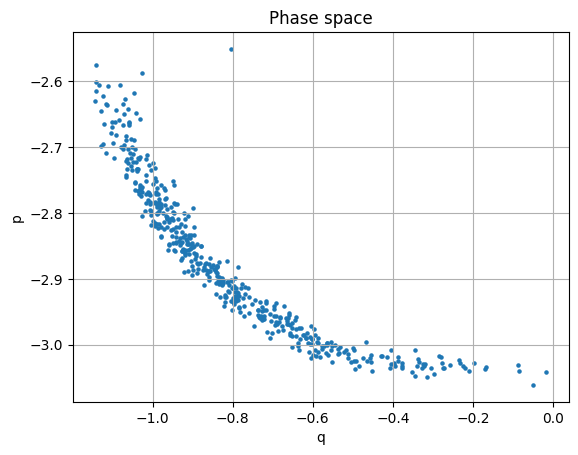

In [125]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define a global random key
global_key = jax.random.PRNGKey(0)

# Define a global variable to switch between Hamiltonian and Langevin mechanics
EOM = 'HMC'
EOM = 'Langevin'
EOM = 'Hamilton'

# Define the potential energy for the confined sinusoidal potential
def potential(q):
    k1, k2 = 1.0, 0.5  # Spring constants for the two wells
    q1, q2 = -1.0, 1.0  # Positions of the wells
    V1 = 0.5 * k1 * (q - q1)**2  # Potential energy of the first well
    V2 = 0.5 * k2 * (q - q2)**2  # Potential energy of the second well
    V = -jnp.exp(-(q - q1)**2) - jnp.exp(-(q - q2)**2) + V1 + V2  # Combined potential
    return V

# Define the Hamiltonian for the system
def hamiltonian(q, p):
    m = 1.0  # mass
    T = p**2 / (2 * m)  # Kinetic energy
    V = potential(q)  # Potential energy
    return T + V

# Compute the equations of motion
def equations_of_motion(q, p, key):
    H_q = grad(hamiltonian, argnums=0)
    H_p = grad(hamiltonian, argnums=1)
    dq_dt = H_p(q, p)
    dp_dt = -H_q(q, p)
    if EOM == 'Langevin':
        m = 1.0  # mass
        gamma = 0.5  # Friction coefficient
        noise = jnp.sqrt(2.* gamma) * jax.random.normal(key, p.shape) 
        #jax.debug.print(f'noise{noise}')
        dp_dt += -gamma * p / m + noise  # Adding damping and noise term
    return dq_dt, dp_dt

# Vectorize the equations of motion for multiple particles
vec_equations_of_motion = vmap(equations_of_motion, in_axes=(0, 0, 0))

# Time evolution function 
@jit
def symplectic_euler_step(q, p, dt, key):
    keylist = jax.random.split(key, num=num_particles)
    dq_dt, dp_dt = vec_equations_of_motion(q, p, keylist)
    if EOM == 'Hamilton': # For this example the simpler update for HMC worked fine
        p_new = p + dp_dt * dt
        q_new = q + dq_dt * dt
    else : # Leapfrog update as in Betancourt et al. 2017
        p_half = p + dp_dt * dt / 2  # First half-step for p
        q_new = q + dq_dt * dt       # Full step for q
        keylist = jax.random.split(key, num=num_particles)
        _, dp_dt_new = vec_equations_of_motion(q_new, p_half, keylist)  # Recalculate derivatives
        p_new = p_half + dp_dt_new * dt / 2  # Second half-step for p

    return q_new, p_new

# Initial conditions for multiple particles
num_particles = 500
key = jax.random.PRNGKey(0) # Allways returns the same random keys
q_init = jax.random.normal(key, (num_particles,), dtype=jnp.float32) * 0.05 - 2.0
key, subkey = jax.random.split(key) # Creates new keys both key and subkey are new keys
p_init = jax.random.normal(subkey, (num_particles,), dtype=jnp.float32) * 0.05

# Time integration
dt = 0.01
num_steps = 5000

# Initialize arrays to store trajectories
q_traj = jnp.zeros((num_steps, num_particles))
p_traj = jnp.zeros((num_steps, num_particles))
q_traj = q_traj.at[0].set(q_init)
p_traj = p_traj.at[0].set(p_init)

# Integrate the equations of motion
q, p = q_init, p_init
for t in range(1, num_steps):
    key, subkey = jax.random.split(key) # Creates new keys both key and subkey are new keys
    q, p = symplectic_euler_step(q, p, dt, subkey)
    if (EOM == 'HMC' and t % 300 == 0): # Resample the momentum every 300 steps in HMC
        key, subkey = jax.random.split(key) # Creates new keys both key and subkey are new keys
        p = jax.random.normal(subkey, (num_particles,), dtype=jnp.float32) * 1.0
    
    q_traj = q_traj.at[t].set(q)
    p_traj = p_traj.at[t].set(p)


# Plot the points in the phase space at the end of the simulation
plt.scatter(q, p, s=5)
plt.xlabel('q')
plt.ylabel('p')
plt.title('Phase space')
plt.grid(True)
plt.show()


### Creating the movie in Phase Space

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


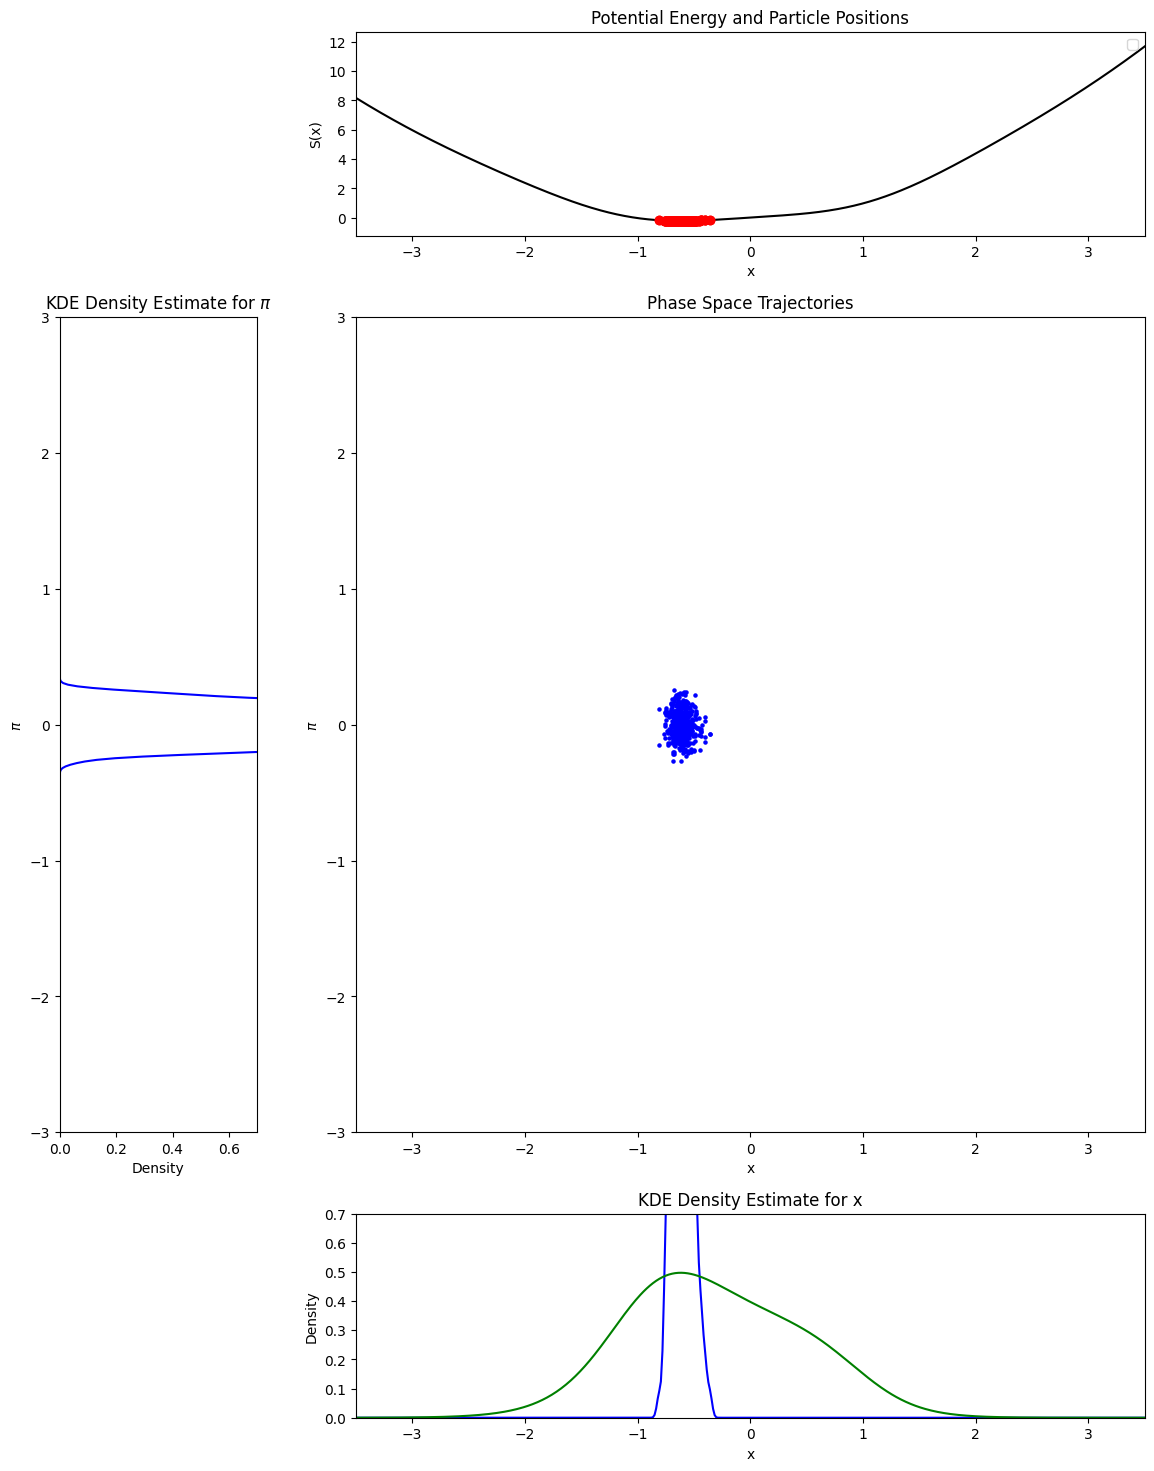

In [123]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import gaussian_kde
from scipy.integrate import quad

q_min, q_max = -3.5, 3.5
p_min, p_max = -3.0, 3.0
skip_steps = 50
q_max_density = 3.5
frames = range(0, num_steps, skip_steps)

## For HMC
skip_steps = 1
frames = range(0, num_steps, skip_steps)
q_max_density = 0.7
p_max_density = 0.7


# Update function for the animation with marginal density plots
def update(frame):
    # Update scatter plot for phase space trajectories
    scatter.set_offsets(jnp.c_[q_traj[frame], p_traj[frame]])

    # Update particle positions on the potential energy plot
    particle_positions.set_data(q_traj[frame], potential(q_traj[frame]))

    # Compute and update KDE density estimate for q
    kde_q = gaussian_kde(q_traj[frame])
    q_kde_vals = jnp.linspace(-q_max, q_max, 500)
    kde_q_vals = kde_q(q_kde_vals)
    kde_q_line.set_data(q_kde_vals, kde_q_vals)

    # Compute and update KDE density estimate for p
    kde_p = gaussian_kde(p_traj[frame])
    p_kde_vals = jnp.linspace(p_min, p_max, 500)
    kde_p_vals = kde_p(p_kde_vals)
    kde_p_line.set_data(kde_p_vals, p_kde_vals)

    return scatter, particle_positions, kde_q_line, kde_p_line

# Create a figure and axis for the animation
fig, ax = plt.subplots(3, 2, figsize=(14, 18), gridspec_kw={'height_ratios': [1, 4, 1], 'width_ratios': [1, 4]})

# Prepare the potential plot
q_vals = jnp.linspace(q_min, q_max, 500)
V_vals = potential(q_vals)
ax[0, 1].plot(q_vals, V_vals, 'k-')
particle_positions, = ax[0, 1].plot([], [], 'ro')
ax[0, 1].set_xlim(q_min, q_max)
ax[0, 1].set_ylim(V_vals.min() - 1, V_vals.max() + 1)
ax[0, 1].set_xlabel('x')
ax[0, 1].set_ylabel('S(x)')
ax[0, 1].set_title('Potential Energy and Particle Positions')
ax[0, 1].legend()

# Initialize the plots
scatter = ax[1, 1].scatter(q_traj[0], p_traj[0], c='blue', s=5)
ax[1, 1].set_xlim(q_min, q_max)
ax[1, 1].set_ylim(p_min, p_max)
ax[1, 1].set_xlabel('x')
ax[1, 1].set_ylabel('$\pi$')
ax[1, 1].set_title('Phase Space Trajectories')

# KDE plot for q
kde_q_line, = ax[2, 1].plot([], [], 'b-', label='KDE Density for x')
ax[2, 1].set_xlim(q_min, q_max)
ax[2, 1].set_ylim(0, q_max_density)
ax[2, 1].set_xlabel('x')
ax[2, 1].set_ylabel('Density')
ax[2, 1].set_title('KDE Density Estimate for x')

### Plot exp(-V(x)) for the potential
integrand = lambda q: jnp.exp(-potential(q))
Z, _ = quad(integrand, q_min, q_max)
ax[2, 1].plot(q_vals, jnp.exp(-potential(q_vals)) / Z, 'g-')


#ax[2, 1].legend()

# KDE plot for p
kde_p_line, = ax[1, 0].plot([], [], 'b-', label='KDE Density for $\pi$')
ax[1, 0].set_xlim(0, p_max_density)
ax[1, 0].set_ylim(p_min, p_max)
ax[1, 0].set_xlabel('Density')
ax[1, 0].set_ylabel('$\pi$')
ax[1, 0].set_title('KDE Density Estimate for $\pi$')
#ax[1, 0].legend()

# Hide the unused subplots
ax[0, 0].axis('off')
ax[2, 0].axis('off')

# Create the animation
# Reducing the number of frames by skipping steps for draft mode

ani = animation.FuncAnimation(fig, update, frames=frames, interval=10, blit=True)

# To save the animation as a GIF (optional)
#ani.save('phase_space_animation.gif', writer='pillow')
ani.save('phase_space_animation_{}.mp4'.format(EOM), writer='ffmpeg')

plt.show()

### Single Partice in the potential

/var/folders/bk/0vv7sh9n43n3dm4fth1qw93r0000gq/T/ipykernel_3685/1049554526.py:23: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  particle_position.set_data(q_single[frame], potential(q_single[frame]))
/var/folders/bk/0vv7sh9n43n3dm4fth1qw93r0000gq/T/ipykernel_3685/1049554526.py:23: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  particle_position.set_data(q_single[frame], potential(q_single[frame]))


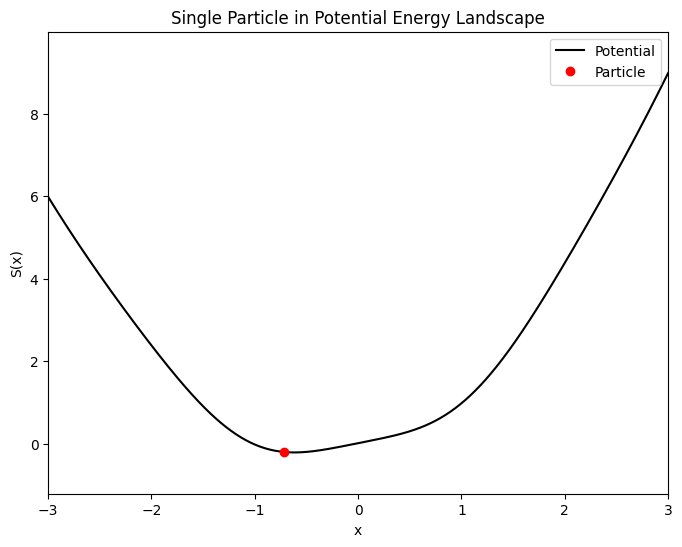

In [121]:
# Get the trajectory of the first particle
q_single = q_traj[:, 0]
p_single = p_traj[:, 0]

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(8, 6))

# Prepare the potential plot
q_vals = jnp.linspace(-3, 3, 500)
V_vals = potential(q_vals)
ax.plot(q_vals, V_vals, 'k-', label='Potential')
particle_position, = ax.plot([], [], 'ro', label='Particle')
ax.set_xlim(-3, 3)
ax.set_ylim(V_vals.min() - 1, V_vals.max() + 1)
ax.set_xlabel('x')
ax.set_ylabel('S(x)')
ax.set_title('Single Particle in Potential Energy Landscape')
ax.legend()

# Update function for the animation
def update(frame):
    # Update particle position on the potential energy plot
    particle_position.set_data(q_single[frame], potential(q_single[frame]))
    return particle_position,

# Create the animation
# Reducing the number of frames by skipping steps for draft mode
#skip_steps = 10
ani = animation.FuncAnimation(fig, update, frames=range(0, num_steps, skip_steps), interval=100, blit=True)

# To save the animation as a GIF (optional)
#ani.save('single_particle_animation.gif', writer='pillow')
ani.save('single_particle_animation_{}.mp4'.format(EOM), writer='ffmpeg')

plt.show()